In [4]:
import pandas as pd
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis, entropy
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import cupy as cp

C:\Users\DELL\.virtualenvs\Emotion-Recognition-kuwpk_hL\Lib\site-packages\cupy\_environment.py:487: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


In [5]:
final_df = pd.read_csv("../Extracted_Features/EEG_Decomposed_Features.csv")
features_df = pd.read_csv("../Extracted_Features/Statistical_Features.csv")

In [8]:
def perform_anova(features_df, target_variable):
    anova_results = {}
    for feature in features_df.columns.difference([target_variable, 'participant_no', 'video_no', 'Target_Emotion']):
        formula = f'{feature} ~ C({target_variable})'
        model = ols(formula, data=features_df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        anova_results[feature] = anova_table['PR(>F)'][0]  # p-value
    
    # Select features with p-value < 0.05 (or another threshold)
    significant_features = [feature for feature, p_value in anova_results.items() if p_value < 0.05]
    return significant_features

In [9]:
significant_features_arousal = perform_anova(features_df, 'Arousal')
significant_features_valence = perform_anova(features_df, 'Valence')

/tmp/ipykernel_55426/1701440488.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  anova_results[feature] = anova_table['PR(>F)'][0]  # p-value
/tmp/ipykernel_55426/1701440488.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  anova_results[feature] = anova_table['PR(>F)'][0]  # p-value
/tmp/ipykernel_55426/1701440488.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  anova_results[feature] = anova_table['PR(>F)'][0]  # p-value
/

In [11]:
len(significant_features_arousal)

34

In [15]:
def evaluate_model(features_df, target_variable, significant_features):
    X = features_df[significant_features]
    y = features_df[target_variable]

    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    accuracy_scores = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)
        print(classification_report(y_test, y_pred))
    
    print(f'Mean Accuracy: {np.mean(accuracy_scores)}')

In [16]:
# Evaluate models separately for Arousal and Valence
print("Evaluating for Arousal:")
evaluate_model(features_df, 'Arousal', significant_features_arousal)

print("\nEvaluating for Valence:")
evaluate_model(features_df, 'Valence', significant_features_valence)

Evaluating for Arousal:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.44      0.36      0.40        11
           3       0.50      0.62      0.55        13
           4       0.38      0.55      0.44        11
           5       0.00      0.00      0.00         6

    accuracy                           0.43        42
   macro avg       0.26      0.30      0.28        42
weighted avg       0.37      0.43      0.39        42



/home/msvelan/anaconda3/envs/summer_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/msvelan/anaconda3/envs/summer_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/msvelan/anaconda3/envs/summer_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.17      0.33      0.22         6
           3       0.27      0.29      0.28        14
           4       0.27      0.33      0.30        12
           5       0.00      0.00      0.00         7

    accuracy                           0.24        42
   macro avg       0.14      0.19      0.16        42
weighted avg       0.19      0.24      0.21        42

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
           2       0.50      0.13      0.21        15
           3       0.25      0.30      0.27        10
           4       0.32      0.80      0.46        10
           5       0.00      0.00      0.00         2

    accuracy                           0.31        42
   macro avg       0.21      0.25      0.19        42
weighted avg       0.31      0.31      0.25        42



/home/msvelan/anaconda3/envs/summer_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/msvelan/anaconda3/envs/summer_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/msvelan/anaconda3/envs/summer_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.29      0.25      0.27         8
           3       0.16      0.27      0.20        11
           4       0.19      0.19      0.19        16
           5       0.00      0.00      0.00         3

    accuracy                           0.19        42
   macro avg       0.13      0.14      0.13        42
weighted avg       0.17      0.19      0.17        42

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.44      0.44      0.44         9
           3       0.29      0.27      0.28        15
           4       0.29      0.42      0.34        12
           5       0.00      0.00      0.00         3

    accuracy                           0.32        41
   macro avg       0.20      0.23      0.21        41
weighted avg       0.29      0.32      0.30        41



/home/msvelan/anaconda3/envs/summer_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/msvelan/anaconda3/envs/summer_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/msvelan/anaconda3/envs/summer_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.17      0.33      0.22         6
           3       0.41      0.47      0.44        15
           4       0.55      0.43      0.48        14
           5       0.00      0.00      0.00         4

    accuracy                           0.37        41
   macro avg       0.22      0.25      0.23        41
weighted avg       0.36      0.37      0.36        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.25      0.30      0.27        10
           3       0.62      0.38      0.48        13
           4       0.35      0.64      0.45        11
           5       0.00      0.00      0.00         7

    accuracy                           0.37        41
   macro avg       0.25      0.26      0.24        41
weighted avg       0.35      0.37      0.34        41



/home/msvelan/anaconda3/envs/summer_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/msvelan/anaconda3/envs/summer_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/msvelan/anaconda3/envs/summer_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.67      0.40      0.50        10
           3       0.39      0.70      0.50        10
           4       0.24      0.36      0.29        11
           5       0.00      0.00      0.00         7

    accuracy                           0.37        41
   macro avg       0.26      0.29      0.26        41
weighted avg       0.32      0.37      0.32        41

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.40      0.20      0.27        10
           3       0.27      0.44      0.33         9
           4       0.53      0.56      0.54        18
           5       0.00      0.00      0.00         3

    accuracy                           0.39        41
   macro avg       0.24      0.24      0.23        41
weighted avg       0.39      0.39      0.38        41



/home/msvelan/anaconda3/envs/summer_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/msvelan/anaconda3/envs/summer_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/msvelan/anaconda3/envs/summer_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           2       0.43      0.38      0.40         8
           3       0.31      0.44      0.36         9
           4       0.52      0.65      0.58        17
           5       0.00      0.00      0.00         7

    accuracy                           0.44        41
   macro avg       0.32      0.37      0.34        41
weighted avg       0.37      0.44      0.40        41

Mean Accuracy: 0.34105691056910564

Evaluating for Valence:
              precision    recall  f1-score   support

           1       0.71      0.56      0.62         9
           2       0.20      0.25      0.22         8
           3       0.31      0.40      0.35        10
           4       0.44      0.40      0.42        10
           5       0.33      0.20      0.25         5

    accuracy                           0.38        42
   macro avg       0.40      0.36      0.37        42
weighted avg       0.41      0.38      0.39        42

              pr

In [26]:
final_df = pd.read_csv("../Extracted_Features/Final_Valence_Features.csv")

## Code for accuracy in emotion detection

In [1]:
from tensorflow.keras.utils import to_categorical

In [22]:
import pickle
import pandas as pd

with open('../Extracted_Features/Final_Valence_Features.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    final_df = pickle.load(f)

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

# Assuming 'final_df' is already loaded

# Define the target variable
target = 'Target_Emotion'

# Extract DWT features
dwt_features = [col for col in final_df.columns if col.endswith(('_alpha', '_beta', '_gamma', '_theta'))]

# Extract IMF features
imf_features = [col for col in final_df.columns if col.endswith(tuple([f'_IMF_{i}' for i in range(1, 7)]))]


In [24]:
# Encode the target variable
label_encoder = LabelEncoder()
final_df[target] = label_encoder.fit_transform(final_df[target])

In [25]:
# Prepare the data for DWT model
X_dwt = final_df[dwt_features]
y_dwt = final_df[target]

# Prepare the data for IMF model
X_imf = final_df[imf_features]
y_imf = final_df[target]

In [26]:
len(X_imf.columns)

84

In [29]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Sample data creation for illustration
# X_imf should be replaced with your actual dataframe
# Assuming X_imf is a dataframe with lists of 7680 elements

# Function to flatten columns containing lists into a 2D array
def flatten_columns(df):
    return np.array(df.iloc[:, :len(df.columns)].values.tolist()).reshape(df.shape[0], -1)

flattened_data = flatten_columns(X_imf)

# Verify the shape of the flattened data
print(f'Flattened data shape: {flattened_data.shape}')


Flattened data shape: (414, 645120)


In [30]:
# Standardize the flattened data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(flattened_data)

# Verify the shape and mean/std of standardized data
print(f'Standardized data shape: {standardized_data.shape}')
print(f'Mean of standardized data: {np.mean(standardized_data, axis=0)}')
print(f'Standard deviation of standardized data: {np.std(standardized_data, axis=0)}')


Standardized data shape: (414, 645120)
Mean of standardized data: [ 2.54426110e-17 -1.30732784e-18  6.13438447e-18 ... -4.34770309e-17
  2.98338917e-18 -5.19076194e-17]
Standard deviation of standardized data: [1. 1. 1. ... 1. 1. 1.]


In [31]:
standardized_data

array([[-0.04023402, -0.0141778 ,  0.01173323, ...,  0.06932789,
         0.06952025,  0.06971317],
       [-0.00157723,  0.01109059,  0.01422422, ...,  0.03071445,
         0.03056671,  0.0304188 ],
       [ 0.00046726, -0.0129734 , -0.01715143, ...,  0.03605694,
         0.03588377,  0.03570981],
       ...,
       [-0.06355163, -0.04194557, -0.00347626, ...,  0.0598989 ,
         0.06000525,  0.06011187],
       [-0.05855131, -0.03854   , -0.0092354 , ...,  0.04768104,
         0.04766036,  0.04763981],
       [-0.06607835, -0.0552283 , -0.03544074, ...,  0.04283855,
         0.04268798,  0.04253574]])

todo: add model code using pytorch from Raw_data.ipynb to predict the accuracy when using IMF data

In [37]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(standardized_data, y_imf, test_size=0.2, random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest classifier
classifier = RandomForestClassifier(random_state=42)

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print(f'Best parameters found: {grid_search.best_params_}')

# Train the model with the best parameters
best_classifier = grid_search.best_estimator_
best_classifier.fit(X_train, y_train)

# Predict on test data
y_pred = best_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Detailed classification report
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.13
Classification Report:
              precision    recall  f1-score   support

   amusement       0.27      0.38      0.32         8
       anger       0.11      0.11      0.11         9
    calmness       0.20      0.18      0.19        11
     disgust       0.17      0.08      0.11        12
  excitement       0.11      0.09      0.10        11
        fear       0.27      0.27      0.27        11
   happiness       0.00      0.00      0.00         8
     sadness       0.00      0.00      0.00         8
    surprise       0.00      0.00      0.00         5

    accuracy                           0.13        83
   macro avg       0.13      0.12      0.12        83
weighted avg       0.14      0.13      0.13        83



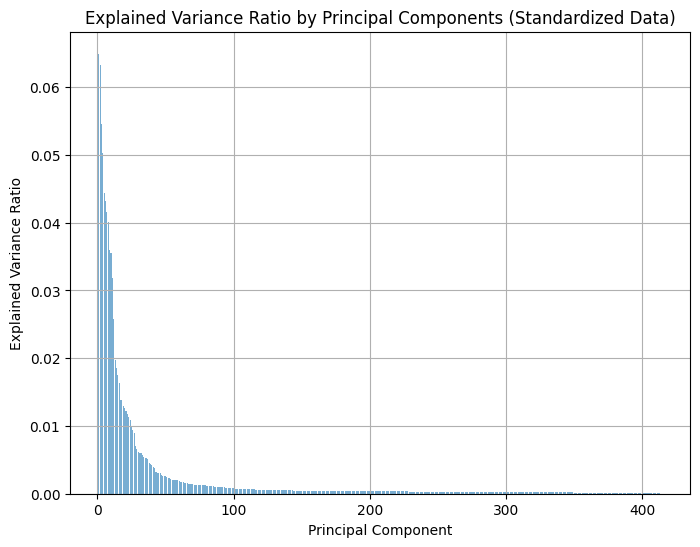

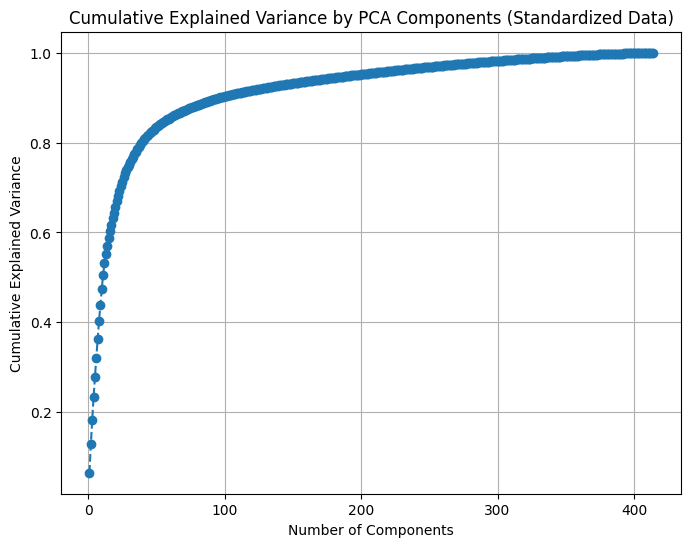

Number of components to retain 99.99% variance: 412


In [32]:
# Fit PCA to the standardized data
pca = PCA()
pca.fit(standardized_data)

# Explained variance ratio for standardized data
explained_variance_ratio_standardized = pca.explained_variance_ratio_

# Plot the explained variance ratio for standardized data
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio_standardized) + 1), explained_variance_ratio_standardized, alpha=0.6)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Components (Standardized Data)')
plt.grid(True)
plt.show()

# Compute cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio_standardized)

# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components (Standardized Data)')
plt.grid(True)
plt.show()

# Determine the number of components to retain 95% of the variance
threshold = 0.9999
num_components = np.argmax(cumulative_explained_variance >= threshold) + 1
print(f'Number of components to retain {threshold*100}% variance: {num_components}')


In [33]:
# Apply PCA with the optimal number of components
pca_optimal = PCA(n_components=num_components)
reduced_data = pca_optimal.fit_transform(standardized_data)

# Verify the shape of the reduced data
print(f'Reduced data shape: {reduced_data.shape}')

Reduced data shape: (414, 412)


In [34]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(reduced_data, y_imf, test_size=0.2, random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest classifier
classifier = RandomForestClassifier(random_state=42)

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print(f'Best parameters found: {grid_search.best_params_}')

# Train the model with the best parameters
best_classifier = grid_search.best_estimator_
best_classifier.fit(X_train, y_train)

# Predict on test data
y_pred = best_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Detailed classification report
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.10
Classification Report:
              precision    recall  f1-score   support

   amusement       0.08      0.12      0.10         8
       anger       0.00      0.00      0.00         9
    calmness       0.00      0.00      0.00        11
     disgust       0.20      0.08      0.12        12
  excitement       0.25      0.09      0.13        11
        fear       0.17      0.09      0.12        11
   happiness       0.00      0.00      0.00         8
     sadness       0.33      0.38      0.35         8
    surprise       0.05      0.20      0.08         5

    accuracy                           0.10        83
   macro avg       0.12      0.11      0.10        83
weighted avg       0.13      0.10      0.10        83



In [35]:
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
# Define the base models
clf1 = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, min_samples_leaf=2, bootstrap=True, random_state=42)
clf2 = GradientBoostingClassifier(random_state=42)
clf3 = SVC(kernel='rbf', probability=True, random_state=42)

# Create the ensemble model
ensemble_model = VotingClassifier(estimators=[
    ('rf', clf1), ('gb', clf2), ('svc', clf3)], voting='soft')

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Predict on test data
y_pred = ensemble_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Detailed classification report
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Accuracy: 0.10
Classification Report:
              precision    recall  f1-score   support

   amusement       0.00      0.00      0.00         8
       anger       0.07      0.11      0.09         9
    calmness       0.33      0.09      0.14        11
     disgust       0.33      0.08      0.13        12
  excitement       0.25      0.18      0.21        11
        fear       0.33      0.09      0.14        11
   happiness       0.00      0.00      0.00         8
     sadness       0.08      0.12      0.10         8
    surprise       0.05      0.20      0.07         5

    accuracy                           0.10        83
   macro avg       0.16      0.10      0.10        83
weighted avg       0.19      0.10      0.11        83



### The above thing is used for pca

In [33]:
len(X_imf["AF3_IMF_1"].iloc[0])

7680

In [38]:
# Function to flatten columns containing lists into multiple columns
def flatten_columns(df, columns):
    flattened_data = pd.DataFrame()
    for col in columns:
        # Create a new DataFrame with each list element as a separate column
        flattened_cols = pd.DataFrame(df[col].tolist(), index=df.index).add_prefix(f'{col}_')
        flattened_data = pd.concat([flattened_data, flattened_cols], axis=1)
    return flattened_data

In [39]:
# Flatten the DWT and IMF columns
flattened_dwt = flatten_columns(X_dwt, dwt_features)

flattened_imf = flatten_columns(X_imf, imf_features)

In [40]:
# Ensure all values are numeric
flattened_dwt = flattened_dwt.apply(pd.to_numeric, errors='coerce')
flattened_imf = flattened_imf.apply(pd.to_numeric, errors='coerce')

In [41]:
# Drop any rows with missing values
flattened_dwt.dropna(inplace=True)
flattened_imf.dropna(inplace=True)

In [42]:
# Prepare the data for DWT model
X_dwt = flattened_dwt
y_dwt = final_df.loc[flattened_dwt.index, target]  # Align the target variable with the filtered DataFrame

# Prepare the data for IMF model
X_imf = flattened_imf
y_imf = final_df.loc[flattened_imf.index, target]  # Align the target variable with the filtered DataFrame

In [43]:
# Standardize the features
scaler = StandardScaler()
X_imf = scaler.fit_transform(X_imf)

scaler2 = StandardScaler()
X_dwt = scaler2.fit_transform(X_dwt)

In [44]:
# Split the data into training and testing sets
# Don't do this while doing Conv1D 
X_dwt_train, X_dwt_test, y_dwt_train, y_dwt_test = train_test_split(X_dwt, y_dwt, test_size=0.2, random_state=42)
X_imf_train, X_imf_test, y_imf_train, y_imf_test = train_test_split(X_imf, y_imf, test_size=0.2, random_state=42)

In [45]:
# Train a model using DWT features
dwt_model = xgb.XGBClassifier()
dwt_model.fit(X_dwt_train, y_dwt_train)

# Predict and evaluate the DWT model
y_dwt_pred = dwt_model.predict(X_dwt_test)
print("DWT Model Accuracy:", accuracy_score(y_dwt_test, y_dwt_pred))
print("DWT Model Classification Report:\n", classification_report(y_dwt_test, y_dwt_pred))

DWT Model Accuracy: 0.13253012048192772
DWT Model Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.25      0.22         8
           1       0.00      0.00      0.00         9
           2       0.20      0.18      0.19        11
           3       0.17      0.08      0.11        12
           4       0.25      0.18      0.21        11
           5       0.00      0.00      0.00        11
           6       0.12      0.12      0.12         8
           7       0.11      0.12      0.12         8
           8       0.25      0.40      0.31         5

    accuracy                           0.13        83
   macro avg       0.14      0.15      0.14        83
weighted avg       0.14      0.13      0.13        83



## Using Conv1D neural network

In [51]:
# Reshape the data to fit the RNN model: (samples, time_steps, features)
import numpy as np
num_samples = X_imf.shape[0]
num_time_steps = 1  # Treat each sample as a single time step
num_features = 645120
X_imf = X_imf.reshape((num_samples, num_time_steps, num_features))
X_imf = np.array(X_imf)

In [47]:
# Convert target to one-hot encoding
y_imf = to_categorical(y_imf)
# Split the data into training and testing sets
X_imf_train, X_imf_test, y_imf_train, y_imf_test = train_test_split(X_imf, y_imf, test_size=0.2, random_state=42)

In [48]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, TimeDistributed, Flatten, Concatenate, Attention
from tensorflow.keras.regularizers import l2

In [61]:
standardized_data.shape

(414, 645120)

In [64]:
# Define the model
def get_model(num_time_steps, num_features, num_classes, _rnn_nb, _fc_nb, dropout_rate=0.5, l2_reg=1e-4):
    spec_start = Input((num_time_steps, num_features))
    spec_x = spec_start

    print(f"Input shape: {spec_start.shape}")

    for _r in _rnn_nb:
        print(f"Passing through GRU layer with {_r} units. Input shape: {spec_x.shape}, dtype: {spec_x.dtype}")
        spec_x = GRU(_r, activation='tanh', dropout=dropout_rate, recurrent_dropout=dropout_rate, return_sequences=True, kernel_regularizer=l2(l2_reg))(spec_x)
        spec_x = Dropout(dropout_rate)(spec_x)
        print(f"Output shape after GRU layer: {spec_x.shape}")

    attention = Attention()([spec_x, spec_x])
    attended = Attention()([spec_x, attention])
    spec_x = Concatenate(axis=-1)([spec_x, attended])

    for _f in _fc_nb:
        spec_x = TimeDistributed(Dense(_f, activation='relu', kernel_regularizer=l2(l2_reg)))(spec_x)
        spec_x = Dropout(dropout_rate)(spec_x)

    out = TimeDistributed(Dense(num_classes, activation='softmax'))(spec_x)
    out = Flatten()(out)
    out = Dense(num_classes, activation='softmax')(out)

    _model = Model(inputs=spec_start, outputs=out)
    _model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    _model.summary()

    return _model

In [65]:
# Reshape the data to fit the RNN model: (samples, time_steps, features)
num_samples = standardized_data.shape[0]
num_time_steps = 1  # Treat each sample as a single time step
num_features = standardized_data.shape[1]
X_imf_reshaped = standardized_data.reshape((num_samples, num_time_steps, num_features))
print(f'Reshaped data shape: {X_imf_reshaped.shape}')
y_one_hot = to_categorical(y_encoded)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imf_reshaped, y_one_hot, test_size=0.2, random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

Reshaped data shape: (414, 1, 645120)
X_train shape: (331, 1, 645120)
y_train shape: (331, 9)


In [66]:
# Model parameters
_rnn_nb = [64, 64]  # Number of units in GRU layers
_fc_nb = [64, 64]   # Number of units in Dense layers
num_classes = y_one_hot.shape[1]  # Number of unique emotions

# Get the model
model = get_model(num_time_steps, num_features, num_classes, _rnn_nb, _fc_nb)


Input shape: (None, 1, 645120)
Passing through GRU layer with 64 units. Input shape: (None, 1, 645120), dtype: float32


ValueError: object __array__ method not producing an array

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')

In [ ]:
# Predict and evaluate the IMF model
y_imf_pred = model.predict(X_imf_test)
y_imf_pred_class = y_imf_pred.argmax(axis=-1)
y_imf_test_class = y_imf_test.argmax(axis=-1)
print("IMF Model Accuracy:", accuracy_score(y_imf_test_class, y_imf_pred_class))
print("IMF Model Classification Report:\n", classification_report(y_imf_test_class, y_imf_pred_class))

## Trying with XGBoost for IMF

In [ ]:
# Train a model using IMF features
imf_model = xgb.XGBClassifier()
imf_model.fit(X_imf_train, y_imf_train)

In [37]:
# Predict and evaluate the IMF model
y_imf_pred = imf_model.predict(X_imf_test)
print("IMF Model Accuracy:", accuracy_score(y_imf_test, y_imf_pred))
print("IMF Model Classification Report:\n", classification_report(y_imf_test, y_imf_pred))

IMF Model Accuracy: 0.14457831325301204
IMF Model Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.12      0.15         8
           1       0.14      0.11      0.12         9
           2       0.33      0.36      0.35        11
           3       0.17      0.17      0.17        12
           4       0.00      0.00      0.00        11
           5       0.11      0.09      0.10        11
           6       0.19      0.38      0.25         8
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00         5

    accuracy                           0.14        83
   macro avg       0.13      0.14      0.13        83
weighted avg       0.14      0.14      0.14        83



### Data Extraction Full 

In [1]:
import scipy.io as sio
raw = sio.loadmat('../DREAMER_Dataset/DREAMER.mat')

In [2]:
# create new dataframe with emotion, participant, and video data
import numpy as np
a=np.zeros((23,18,9),dtype=object)
for participant in range(0,23):
    for video in range(0,18):
        a[participant,video,0]=raw['DREAMER'][0,0]['Data'][0,participant]['Age'][0][0][0]
        a[participant,video,1]=raw['DREAMER'][0,0]['Data'][0,participant]['Gender'][0][0][0]
        a[participant,video,2]=participant+1
        a[participant,video,3]=video+1
        a[participant,video,4]=['Searching for Bobby Fischer','D.O.A.', 'The Hangover', 'The Ring', '300',
                  'National Lampoon\'s VanWilder', 'Wall-E', 'Crash', 'My Girl', 'The Fly',
                  'Pride and Prejudice', 'Modern Times', 'Remember the Titans', 'Gentlemans Agreement',
                  'Psycho', 'The Bourne Identitiy', 'The Shawshank Redemption', 'The Departed'][video]
        a[participant,video,5]=['calmness', 'surprise', 'amusement', 'fear', 'excitement', 'disgust',
                  'happiness', 'anger', 'sadness', 'disgust', 'calmness', 'amusement',
                  'happiness', 'anger', 'fear', 'excitement', 'sadness', 'surprise'][video]
        a[participant,video,6]=raw['DREAMER'][0,0]['Data'][0,participant]['ScoreValence'][0,0][video,0]
        a[participant,video,7]=raw['DREAMER'][0,0]['Data'][0,participant]['ScoreArousal'][0,0][video,0]
        a[participant,video,8]=raw['DREAMER'][0,0]['Data'][0,participant]['ScoreDominance'][0,0][video,0]
b=pd.DataFrame(a.reshape((23*18,a.shape[2])),columns=['Age','Gender','Participant','Video','Video_Name','Target_Emotion','Valence','Arousal','Dominance'])

NameError: name 'pd' is not defined

In [ ]:
eeg_electrodes = [str(e[0]) for e in raw['DREAMER']['EEG_Electrodes'][0][0][0]]

In [ ]:
def str_to_float_list(s):
    return list(map(float, s.strip('[]').split()))

In [ ]:
import math
def feature_extraction_EEG(raw):
    # 128 Hz is the sampling rate for the EEG data
    fs_EEG = 128
    features = []
    for electrode in eeg_electrodes:
        features += [f'{electrode}'] 
    # DataFrame to store features
    columns = ['participant', 'video'] + features
    df = pd.DataFrame(columns=columns)
    for participant in range(23):
        for video in range(18):
            feature_values = []
            for i in range(14):
                # basl=raw['DREAMER'][0,0]['Data'][0,participant]['EEG'][0,0]['baseline'][0,0][video,0][:,i]
                stimuli = raw['DREAMER'][0,0]['Data'][0,participant]['EEG'][0,0]['stimuli'][0,0][video,0][:,i]
                stimuli_list = list(stimuli)
                # Detrending
                # basl_detrended = detrend_signal(basl)
                # stimuli_detrended = detrend_signal(stimuli)
                
                # Baseline correction
                # stimuli_corrected = baseline_correction(basl_detrended, stimuli_detrended)
                
                # Feature extraction
                # DWT_stimuli = dwt_and_band_extraction([], stimuli_corrected)
                # emd_stimuli = emd(stimuli_corrected)

                # Combine features
                feature_values += stimuli_list
            
            # Append to DataFrame
            row = [participant+1, video+1] + feature_values
            if len(row) == len(columns):
                df.loc[len(df)] = row
            else:
                print(f'Skipping participant {participant+1}, video {video+1}')
                print(len(row))
                print(row)
                print(len(columns))
                print(columns)
    return df

In [ ]:
# secs = 5  # Number of seconds for the EEG data segment
initial_df = feature_extraction_EEG(raw)
initial_df.head()

In [ ]:
import pickle
import numpy as np
import pandas as pd

# An arbitrary collection of objects supported by pickle.
a = [np.arange(0,7000,1), np.arange(7000,14000,1)]
d = [np.arange(7000,14000,1), np.arange(2000,9000,1)]
data = {
    'a': a,
    'b': ["character string", b"byte string"],
    'c': [None, True],
    'd': d
}
df = pd.DataFrame(data)
df

In [18]:
with open('data.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(df, f, pickle.HIGHEST_PROTOCOL)
# The following example reads the resulting pickled data.

In [5]:
import pickle
with open('data.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    df = pickle.load(f)

In [6]:
df

,a,b,c,d
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",character string,None,"[7000, 7001, 7002, 7003, 7004, 7005, 7006, 700..."
1,"[7000, 7001, 7002, 7003, 7004, 7005, 7006, 700...",b'byte string',True,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200..."


In [24]:
df['a'].iloc[1]

array([ 7000,  7001,  7002, ..., 13997, 13998, 13999])